In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string

import sys
import pickle
from pprint import pprint

sys.path.append('../')

import bl_plots_new as blp
from sklearn.metrics import f1_score, matthews_corrcoef

# Spectra

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
../bl_plots_new.py:265: RuntimeWarning: invalid value encountered in double_scalars
  stats['NPV'].append(tn/(tn+fn))
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
../bl_plots_new.py:265: RuntimeWarning: invalid value encountered in double_scalars
  stats['NPV'].append(tn/(tn+fn))
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
../bl_plots_new.py:265: RuntimeWarning: invalid value encountered in double_scalars
  stats['NPV'].append(tn/(tn+fn))
/home/conor/miniconda3

KeyboardInterrupt: 

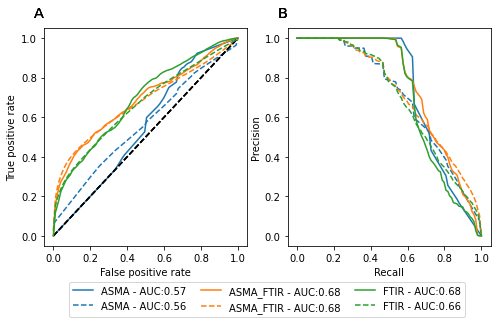

In [7]:
all_results = {}

for group in ['1yeardeath', '2year', 'Opt_Group']:

    group_results = {}
    
    #group = 'Opt_Group'
    datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}
    threshs = {key: blp.get_opt_thresh(dataset) for key, dataset in datasets.items()}

    plot_data = blp.data_plot(datasets, patient=False);
    plot_data.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Spectra/Curves/{group}_roc_pr_curves.pdf', bbox_inches='tight')
    
    # Calculate statistics and save in plots
    stats = blp.calc_stats(datasets, patient=False)
    pprint(stats.groupby('Vars').median().round(3))
    stats.groupby('Vars').median().round(3).to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Spectra/Paper_Plots/Stats/{group}_stats.xlsx')
    plot_box = blp.box_plot(stats.drop(['F1', 'Thresh'], axis=1))
    plot_box.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Spectra/Stats/{group}_stats.pdf', bbox_inches='tight')

    fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True);
    fig.subplots_adjust(wspace=0.05)

    for ax, (key, dataset) in zip(axes.flatten(), datasets.items()):

        dataset.index = dataset.index.set_names('Split',level=0)

        ax.set_title(key.replace('_','+'))
        ax.set_ylim(0,1)
        results = blp.lifelines_plots(dataset, patient=False, thresh=threshs[key], ax=ax)

        group_results[key] = results

    with open(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Spectra/{group}_prognosis_results.pkl', 'wb') as file:

        pickle.dump(file=file, obj=group_results)


    all_results[group] = group_results

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Surv_Curves/{group}_surv_curve.pdf', bbox_inches='tight')

# Patient

In [3]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

## Best prognosis

In [38]:
all_results = {}

for group in ['1yeardeath', '2year', 'Opt_Group']:

    group = 'Opt_Group'

    group_results = {}
    
    #group = 'Opt_Group'
    datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results_March.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}
    threshs = {key: blp.get_opt_prog_thresh(dataset).idxmin() for key, dataset in datasets.items()}

    plot_data = blp.data_plot(datasets, patient=True);
    plot_data.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Curves/{group}_roc_pr_curves.pdf', bbox_inches='tight')
    
    # Calculate statistics and save in plots
    stats = blp.calc_stats(datasets, patient=True, threshold='prog')
    pprint(stats.groupby('Vars').median().round(3))
    stats_table=stats.groupby('Vars').median()
    stats_table.round(3).to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats.xlsx')
    stats_table.round(2).to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats_latex.txt')

    plot_box = blp.box_plot(stats.drop(['F1', 'Thresh'], axis=1))
    plot_box.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats.pdf', bbox_inches='tight')

    fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True);
    fig.subplots_adjust(wspace=0.05)

    #-- KM Plots --#

    for ax, (key, dataset), letter in zip(axes.flatten(), datasets.items(), string.ascii_uppercase):

        dataset.index = dataset.index.set_names('Split',level=0)

        ax.set_title(key.replace('_','+'))
        ax.set_ylim(0,1)
        ax.text(-0.05, 1.05, letter, size='x-large', transform=ax.transAxes)

        thresho = (stats.groupby('Vars').median()['Thresh'][key] + threshs[key])/2
        #thresho = stats.groupby('Vars').median()['Thresh'][key]
        #thresho = threshs[key]

        #results = blp.lifelines_plots(dataset, patient=True, thresh=thresho, ax=ax, add_risk=False)
        results = blp.lifelines_plots(dataset, patient=True, thresh=threshs[key], ax=ax, add_risk=False)
        p = results['Logrank'].p_value

        if p < 0.005:
            ax.text(0.7, 0.8, "p: <0.005", size='medium', transform=ax.transAxes)
        else:
            ax.text(0.7, 0.8, f"p: {p:0.2f}", size='medium', transform=ax.transAxes)
        
        group_results[key] = results

    cox_table = pd.concat({key: group_results[key]['Cox'].summary.round(2) for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}).reset_index(level=1, drop=True)
    cox_table['Hazard ratio'] = cox_table.apply(lambda row: f'{row["exp(coef)"]} ({row["exp(coef) lower 95%"]}-{row["exp(coef) upper 95%"]})', axis=1)

    cox_table.to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_cox_stats.xlsx')
    cox_table.iloc[:,[0,7,8,9]].to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_cox_stats_latex.txt')

    with open(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/{group}_prognosis_results.pkl', 'wb') as file:

        pickle.dump(file=file, obj=group_results)


    all_results[group] = group_results

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_surv_curve.pdf', bbox_inches='tight')
    break

## Best classification

             AUC     F1    MCC  Specificity  Sensitivity    PPV    NPV  Thresh
Vars                                                                          
ASMA       0.456  0.502  0.059        1.000        0.159  0.549  0.874   0.472
ASMA_FTIR  0.917  0.943  0.827        0.954        1.000  0.958  1.000   0.243
FTIR       0.886  0.920  0.774        0.919        1.000  0.915  1.000   0.279
[('AUC', 'C'), ('MCC', 'D'), ('Specificity', 'E'), ('Sensitivity', 'F'), ('PPV', 'G'), ('NPV', 'H')]


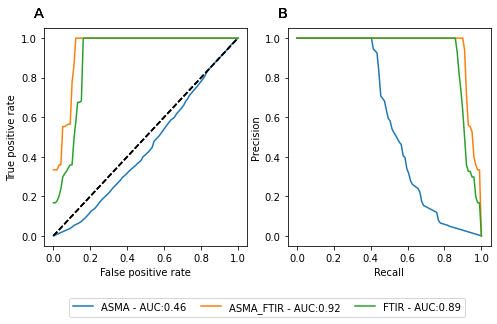

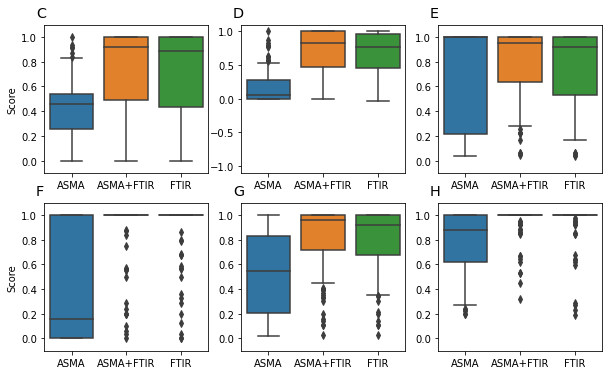

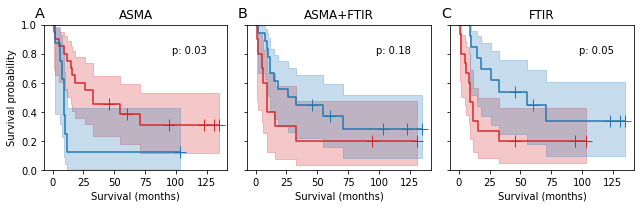

In [36]:
all_results = {}

for group in ['1yeardeath', '2year', 'Opt_Group']:

    group = 'Opt_Group'

    group_results = {}
    
    #group = 'Opt_Group'
    datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results_March.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}
    threshs = {key: blp.get_opt_prog_thresh(dataset).idxmin() for key, dataset in datasets.items()}

    plot_data = blp.data_plot(datasets, patient=True);
    plot_data.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Curves/{group}_roc_pr_curves.pdf', bbox_inches='tight')
    
    # Calculate statistics and save in plots
    stats = blp.calc_stats(datasets, patient=True, threshold='class')
    pprint(stats.groupby('Vars').median().round(3))
    stats_table=stats.groupby('Vars').median()
    stats_table.round(3).to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats.xlsx')
    stats_table.round(2).to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats_latex.txt')

    plot_box = blp.box_plot(stats.drop(['F1', 'Thresh'], axis=1))
    plot_box.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Stats/{group}_stats.pdf', bbox_inches='tight')

    fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True);
    fig.subplots_adjust(wspace=0.05)

    #-- KM Plots --#

    for ax, (key, dataset), letter in zip(axes.flatten(), datasets.items(), string.ascii_uppercase):

        dataset.index = dataset.index.set_names('Split',level=0)

        ax.set_title(key.replace('_','+'))
        ax.set_ylim(0,1)
        ax.text(-0.05, 1.05, letter, size='x-large', transform=ax.transAxes)

        thresho = (stats.groupby('Vars').median()['Thresh'][key] + threshs[key])/2
        #thresho = stats.groupby('Vars').median()['Thresh'][key]
        #thresho = threshs[key]

        results = blp.lifelines_plots(dataset, patient=True, thresh=thresho, ax=ax, add_risk=False)
        #results = blp.lifelines_plots(dataset, patient=True, thresh=threshs[key], ax=ax, add_risk=False)
        p = results['Logrank'].p_value


        if p < 0.005:
            ax.text(0.7, 0.8, "p: <0.005", size='medium', transform=ax.transAxes)
        else:
            ax.text(0.7, 0.8, f"p: {p:0.2f}", size='medium', transform=ax.transAxes)
        
        group_results[key] = results

    cox_table = pd.concat({key: group_results[key]['Cox'].summary.round(2) for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}).reset_index(level=1, drop=True)
    cox_table['Hazard ratio'] = cox_table.apply(lambda row: f'{row["exp(coef)"]} ({row["exp(coef) lower 95%"]}-{row["exp(coef) upper 95%"]})', axis=1)

    cox_table.to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_cox_stats.xlsx')
    cox_table.iloc[:,[0,7,8,9]].to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_cox_stats_latex.txt')

    with open(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/{group}_prognosis_results.pkl', 'wb') as file:

        pickle.dump(file=file, obj=group_results)


    all_results[group] = group_results

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_surv_curve.pdf', bbox_inches='tight')
    break

<AxesSubplot:>

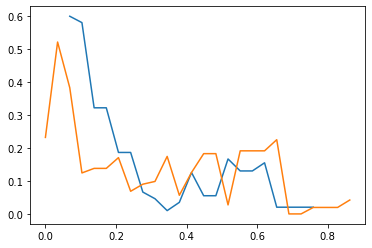

In [34]:
blp.get_opt_prog_thresh(datasets['FTIR']).plot()
blp.get_opt_prog_thresh(datasets['ASMA_FTIR']).plot()

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column Preds have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['DiedvsAlive'].astype(bool)
>>> print(df.loc[events, 'Preds'].var())
>>> print(df.loc[~events, 'Preds'].var())

A very low variance means that the column Preds completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1153: ConvergenceWarning: Column Preds has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange

0.13950150724422217
31


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1592: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1153: ConvergenceWarning: Column Preds has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1592: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in t

0.06027370442685254
42


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1585: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 1.154. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1153: ConvergenceWarning: Column Preds has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1592: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifeli

0.14100118646655138
23


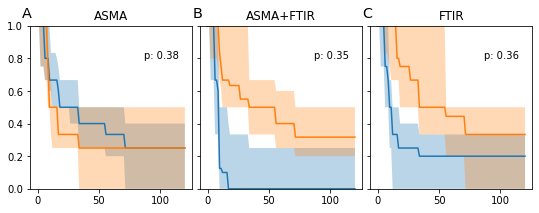

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True);
fig.subplots_adjust(wspace=0.05)


#-- KM Plots --#
for ax, (key, dataset), letter in zip(axes.flatten(), datasets.items(), string.ascii_uppercase):

    dataset.index = dataset.index.set_names('Split',level=0)

    ax.set_title(key.replace('_','+'))
    ax.set_ylim(0,1)
    ax.text(-0.05, 1.05, letter, size='x-large', transform=ax.transAxes)

    #results = blp.lifelines_plots2(dataset, patient=True, thresh=stats.groupby('Vars').median()['Thresh'][key], ax=ax, add_risk=False)
    results = blp.lifelines_plots2(dataset, patient=True, thresh=threshs[key], ax=ax, add_risk=False)
    p = np.median([result['Results'].p_value for result in results])


    if p < 0.005:
        ax.text(0.7, 0.8, "p: <0.005", size='medium', transform=ax.transAxes)
    else:
        ax.text(0.7, 0.8, f"p: {p:0.2f}", size='medium', transform=ax.transAxes)
    
    group_results[key] = results

In [28]:
resul[result['Results'].p_value for result in results]ts[45]['cox'].summary['p'][0]

0.23007320643439907

(array([14.,  7., 10., 11.,  3.,  6.,  6.,  6.,  3., 11.]),
 array([0.00822659, 0.1026675 , 0.19710842, 0.29154933, 0.38599025,
        0.48043116, 0.57487208, 0.66931299, 0.76375391, 0.85819482,
        0.95263574]),
 <BarContainer object of 10 artists>)

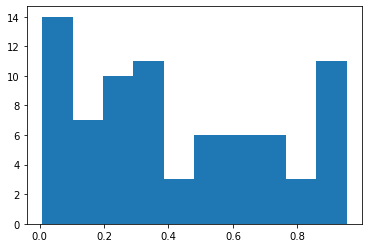

In [31]:
#plt.hist([result['cox'].summary['p'][0] for result in results])
plt.hist([result['Results'].p_value for result in results])

In [6]:
cox_table.iloc[:,[0,7,8,9,10]].to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_cox_stats_latex.txt')

In [7]:
stats.groupby('Vars').median().round(2).iloc[:,:].to_latex(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surv_Curves/{group}_stats_latex.txt')

In [27]:
cox_table

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),Hazard ratio
ASMA,-0.078,0.925,2.260,-4.508,4.353,0.011,77.679,-0.034,0.973,0.040,0.925 (0.011-77.679)
ASMA_FTIR,2.070,7.925,0.941,0.225,3.915,1.253,50.134,2.199,0.028,5.166,7.925 (1.253-50.134)
FTIR,2.017,7.516,0.973,0.110,3.924,1.116,50.620,2.073,0.038,4.710,7.516 (1.116-50.62)


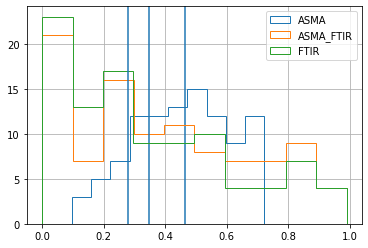

In [25]:
for var, df in stats['Thresh'].groupby('Vars'):

    ax = df.hist(histtype='step', label=var)
    ax.axvline(df.median())

ax.legend()

# Cox

In [9]:
cox_table['Hazard ratio'] = cox_table.apply(lambda row: f'{row["exp(coef)"]} ({row["exp(coef) lower 95%"]}-{row["exp(coef) upper 95%"]})', axis=1)

In [10]:
cox_table

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),Hazard ratio
ASMA,-0.078,0.925,2.260,-4.508,4.353,0.011,77.679,-0.034,0.973,0.040,0.925 (0.011-77.679)
ASMA_FTIR,2.070,7.925,0.941,0.225,3.915,1.253,50.134,2.199,0.028,5.166,7.925 (1.253-50.134)
FTIR,2.017,7.516,0.973,0.110,3.924,1.116,50.620,2.073,0.038,4.710,7.516 (1.116-50.62)


# Extra plots for thesis

In [11]:
cox_table = pd.concat({key: group_results[key]['Cox'].summary.round(3) for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}).reset_index(level=1, drop=True)
cox_table.to_excel(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Patient/Surf/{group}_stats.xlsx')

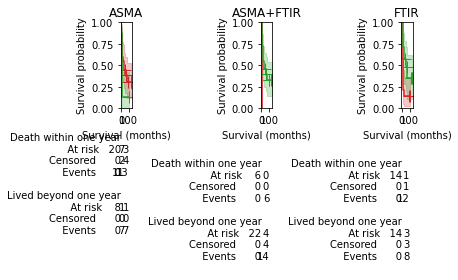

In [14]:
fig, axes = plt.subplots(ncols=3)

for ax, (key, dataset) in zip(axes.flatten(), datasets.items()):

    dataset.index = dataset.index.set_names('Split',level=0)

    ax.set_title(key.replace('_','+'))
    ax.set_ylim(0,1)
    results = blp.lifelines_plots(dataset, patient=True, thresh=threshs[key], ax=ax, add_risk=True)

    group_results[key] = results

plt.show()

In [17]:
all_results['Opt_Group']['ASMA_FTIR']['Cox'].summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Preds,2.06996,7.924504,0.941208,0.225227,3.914693,1.252607,50.133672,2.199259,0.027859,5.165688


In [84]:
## I think I've accidentally done bagging/ pasting here ^

<AxesSubplot:>

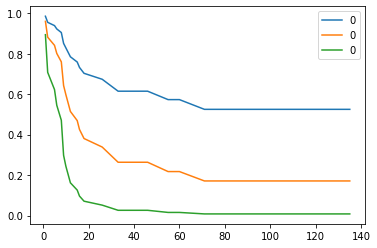

In [21]:
fig, ax = plt.subplots()

all_results['Opt_Group']['FTIR']['Cox'].predict_survival_function(np.array([0]).T).plot(ax=ax)
all_results['Opt_Group']['FTIR']['Cox'].predict_survival_function(np.array([0.5]).T).plot(ax=ax)
all_results['Opt_Group']['FTIR']['Cox'].predict_survival_function(np.array([1]).T).plot(ax=ax)

<AxesSubplot:>

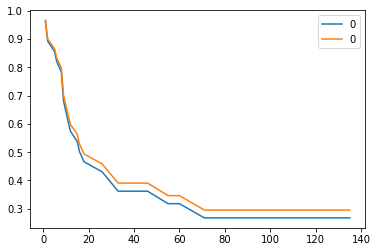

In [19]:
fig, ax = plt.subplots()

all_results['Opt_Group']['ASMA']['Cox'].predict_survival_function(np.array([0]).T).plot(ax=ax)
all_results['Opt_Group']['ASMA']['Cox'].predict_survival_function(np.array([1]).T).plot(ax=ax)

# Old plots

             AUC     F1  MCC  Specificity  Sensitivity    PPV    NPV  Thresh
Vars                                                                        
ASMA       0.555  0.292  0.0        0.156        0.856  0.510  0.332   0.429
ASMA_FTIR  0.842  0.507  0.0        1.000        0.131  0.917  0.530   0.513
FTIR       0.892  0.421  0.0        1.000        0.000  1.000  0.447   0.682
[('AUC', 'A'), ('F1', 'B'), ('Specificity', 'C'), ('Sensitivity', 'D'), ('PPV', 'E'), ('NPV', 'F')]


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column Preds have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['DiedvsAlive'].astype(bool)
>>> print(df.loc[events, 'Preds'].var())
>>> print(df.loc[~events, 'Preds'].var())

A very low variance means that the column Preds completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1585: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.791. This may imply non-unique solutions to the maximum likelihood. Perhaps there is c

0.5601044521337626
39


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/utils/__init__.py:1153: ConvergenceWarning: Column Preds has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1592: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1567: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large.

0.24388097864135108
44


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1567: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

  warnings.warn(
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1592: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


0.24072369614714845
58


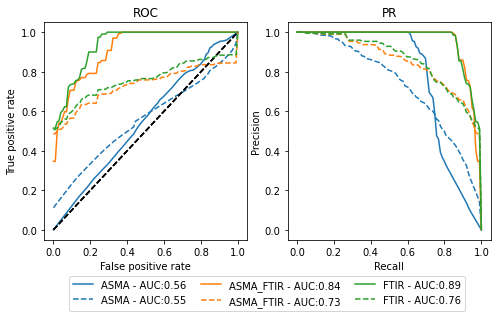

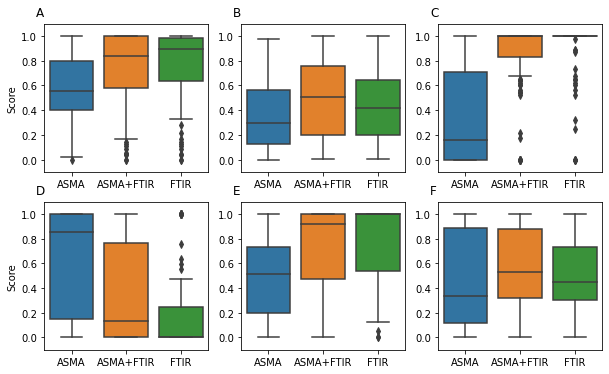

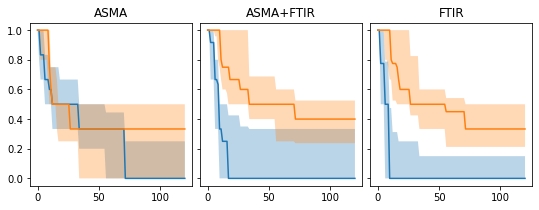

In [37]:
for group in ['1yeardeath', '2year', 'Opt_Group']:
    
    group = '2year'
    datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}
    threshs = {key: blp.get_opt_thresh(dataset) for key, dataset in datasets.items()}

    plot_data = blp.data_plot(datasets, patient=True);
    plot_data.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Curves/{group}_roc_pr_curves.pdf', bbox_inches='tight')
    stats = blp.calc_stats(datasets, patient=True)

    pprint(stats.groupby('Vars').median().round(3))
    plot_box = blp.box_plot(stats.drop(['MCC', 'Thresh'], axis=1))
    plot_box.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Stats/{group}_stats.pdf', bbox_inches='tight')

    fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True);
    fig.subplots_adjust(wspace=0.05)

    for ax, (key, dataset) in zip(axes.flatten(), datasets.items()):

        dataset.index = dataset.index.set_names('Split',level=0)

        ax.set_title(key.replace('_','+'))
        #blp.lifelines_plots(dataset, patient=True, thresh=threshs[key], ax=ax)
        af=blp.lifelines_plots2(dataset, patient=True, thresh=threshs[key], ax=ax)
        #try:
        #    kmco = blp.km_curve(dataset, patient=True, thresh=stats.xs(key,level=0)['Thresh'].median())
        #except Exception as e:
        #    print(e)
        #    continue
        #blp.plot_kcmo(kmco, ax=ax, logp=True)

        #tsi, fsi, ps = blp.km_calculate(dataset.reset_index(['survival (months)', 'DiedvsAlive']), 'survival (months)', 'Preds', 'DiedvsAlive')
        #blp.km_plots(tsi, fsi, axin=ax, ste=True, median=True)

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Surv_Curves/{group}_stats.pdf', bbox_inches='tight')
    break

<AxesSubplot:xlabel='Preds', ylabel='survival (months)'>

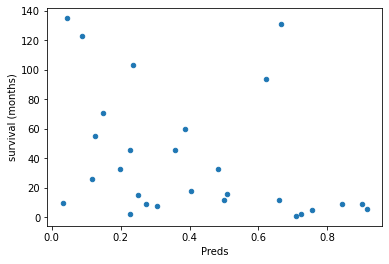

In [42]:
indf.plot.scatter(y='survival (months)', x='Preds')#.groupby([''])

<lifelines.CoxPHFitter: fitted with 28 total observations, 8 right-censored observations>
             duration col = 'survival (months)'
                event col = 'DiedvsAlive'
      baseline estimation = breslow
   number of observations = 28
number of events observed = 20
   partial log-likelihood = -56.66
         time fit was run = 2022-01-10 23:32:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Preds      -0.08       0.93       2.26            -4.51             4.35                 0.01                77.68

              z    p   -log2(p)
covariate                      
Preds     -0.03 0.97       0.04
---
Concordance = 0.56
Partial AIC = 115.31
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.04

Y_true
0.0    [AxesSubplot(0.125,0.125;0.775x0.755)]
1.0    [AxesSubplot(0.125,0.125;0.775x0.755)]
dtype: object

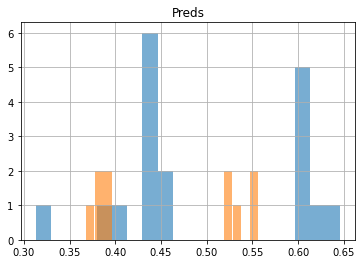

In [48]:
group = 'Opt_Group'
datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}

indf = datasets['ASMA'].copy()#.xs(90, level=0)
indf = indf.reset_index(['DiedvsAlive', 'survival (months)'])
indf['DiedvsAlive'] = 1*(indf['DiedvsAlive']=='Died')
indf.index = indf.index.set_names('Split',level=0)
#indf=indf.groupby(['Split', 'Patient_Number']).mean()
indf=indf.groupby('Patient_Number').median()

cph = CoxPHFitter()
cph.fit(indf[['DiedvsAlive', 'survival (months)', 'Preds']], duration_col='survival (months)', event_col='DiedvsAlive')

cph.print_summary()

fig,ax = plt.subplots()
indf.groupby('Y_true').hist('Preds', bins=20, ax=ax, alpha=0.6)

#plt.hist(np.concatenate([f['cox'].summary['p'] for f in af]), bins=20)

 
Use "mget_thresh(datasets['ASMA_FTIR'], bins=bins)" by making all plot methods individual to variable sets (i.e. like lifelines_plots is). Use the function to find the threshold for all examples which optimises the F1 or something. Then use that threshold on all the rest of the functions

             AUC     F1    MCC  Specificity  Sensitivity   PPV    NPV  Thresh
Vars                                                                         
ASMA       0.555  0.539  0.148        0.361          1.0  0.71  1.000   0.348
ASMA_FTIR  0.888  0.933  0.795        1.000          1.0  1.00  1.000   0.179
FTIR       0.857  0.888  0.710        1.000          1.0  1.00  0.977   0.145
[('AUC', 'A'), ('F1', 'B'), ('Specificity', 'C'), ('Sensitivity', 'D'), ('PPV', 'E'), ('NPV', 'F')]
\begin{tabular}{lrrr}
\toprule
{} &  test\_statistic &         p &  -log2(p) \\
\midrule
0 &        0.759545 &  0.383471 &  1.382811 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  test\_statistic &         p &  -log2(p) \\
\midrule
0 &        2.883468 &  0.089493 &   3.48208 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  test\_statistic &         p &  -log2(p) \\
\midrule
0 &        1.601635 &  0.205672 &  2.281585 \\
\bottomrule
\end{tabular}



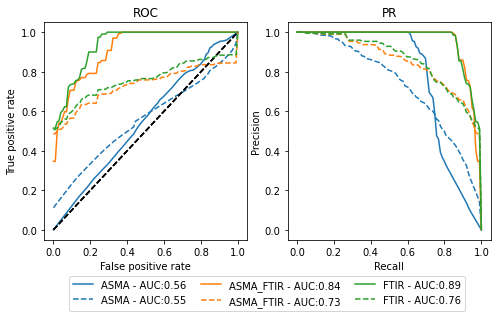

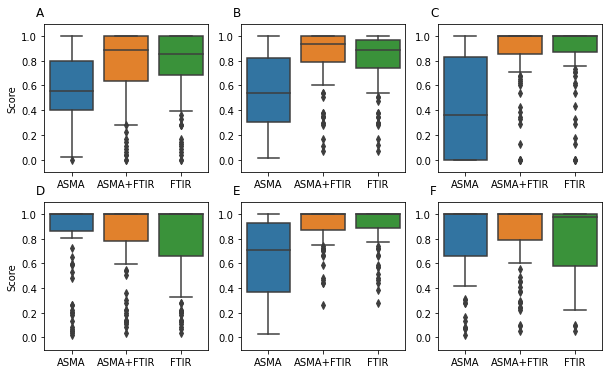

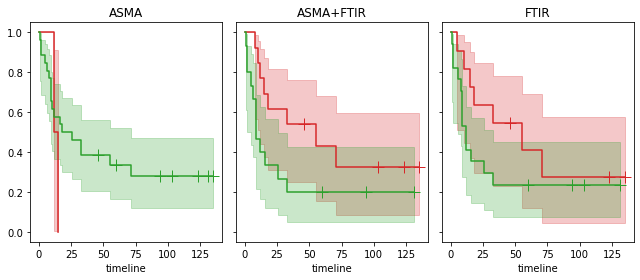

In [ ]:
for group in ['1yeardeath', '2year', 'Opt_Group']:
    
    group = '2year'
    datasets = {key: pd.read_pickle(f'./Results/best_Opt/{group}/{key}/results.pickle') for key in ['ASMA', 'ASMA_FTIR', 'FTIR']}

    plot_data = blp.data_plot(datasets, patient=True);
    plot_data.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Curves/{group}_roc_pr_curves.pdf', bbox_inches='tight')
    stats = blp.calc_stats(datasets, patient=True, best_threshold=1-0.77)

    pprint(stats.groupby('Vars').median().round(3))
    plot_box = blp.box_plot(stats.drop(['MCC', 'Thresh'], axis=1))
    plot_box.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Stats/{group}_stats.pdf', bbox_inches='tight')

    fig, axes = plt.subplots(ncols=3, figsize=(9,4), sharey=True);
    fig.subplots_adjust(wspace=0.05)

    for ax, (key, dataset) in zip(axes.flatten(), datasets.items()):

        ax.set_title(key.replace('_','+'))
        blp.lifelines_plots(dataset, patient=True, thresh=stats.xs(key,level=0)['Thresh'].median(), ax=ax)
        #try:
        #    kmco = blp.km_curve(dataset, patient=True, thresh=stats.xs(key,level=0)['Thresh'].median())
        #except Exception as e:
        #    print(e)
        #    continue
        #blp.plot_kcmo(kmco, ax=ax, logp=True)

        #tsi, fsi, ps = blp.km_calculate(dataset.reset_index(['survival (months)', 'DiedvsAlive']), 'survival (months)', 'Preds', 'DiedvsAlive')
        #blp.km_plots(tsi, fsi, axin=ax, ste=True, median=True)

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/December_Prognosis/Paper_Plots/Surv_Curves/{group}_stats.pdf', bbox_inches='tight')
    break

# Testing

In [14]:
def get_thresh(data):
    
    thresholds = np.linspace(0.01,0.99,30)
    scores = [f1_score(data['Y_true'], (data['Preds']>t), sample_weight=data['Weights'], average='weighted') for t in thresholds]

    return thresholds[np.argmax(scores)], thresholds, scores

def mget_thresh(data, bins=30):
    
    thresholds = np.linspace(data['Preds'].min(), data['Preds'].max(), bins)
    scores = [matthews_corrcoef(data['Y_true'], (data['Preds']>t), sample_weight=data['Weights']) for t in thresholds]

    return thresholds[np.argmax(scores)], thresholds, scores

Thresh: 0.86, score: 0.265
Thresh: 0.40, score: 0.632


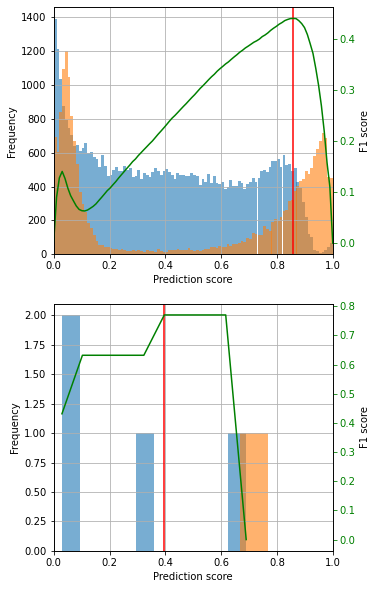

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(5,10))
dss = datasets['FTIR'].xs(key=7,level=0)

for ax, ds, bins in zip(axes.flatten(), [dss, dss.groupby('Patient_Number').median()],[100,10]):
    for n, df in ds.groupby('Y_true'):

        df['Preds'].hist(ax=ax, alpha=0.6, density=False, bins=bins)

    th, ts, scs = mget_thresh(ds, bins=bins)
    print(f'Thresh: {th:0.2f}, score: {np.median(scs):0.3f}')
    ax.axvline(th, c='r')
    ax2=ax.twinx()
    ax2.tick_params(axis='y', colors='g')
    ax2.set_ylabel('F1 score')
    ax2.plot(ts, scs,c='g')
    ax.set_xlabel('Prediction score')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0,1)